# Imports

In [848]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

from itertools import combinations

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pprint import pprint

import joblib

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, QuantileTransformer

from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis, FastICA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import classification_report

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix

%matplotlib inline

# Data

In [849]:
# read training data
train = pd.read_csv("train.csv")

# Clean

In [850]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [851]:
train.set_index('id', inplace=True)

In [891]:
X = train.drop(columns='type')
y = train.type

X_obj = X.select_dtypes(include=['O'])

X_num = X.select_dtypes(exclude=['O'])

# combo_num_cols = list(combinations(X_num.columns, 3)) + list(combinations(X_num.columns, 2))
combo_num_cols2 = list(combinations(X_num.columns, 2))
combo_num_cols3 = list(combinations(X_num.columns, 3))

X_obj["max_column"] = X_num.idxmax(axis=1).copy()

X_obj["min_column"] = X_num.idxmin(axis=1).copy()

/home/ian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [892]:
col_order = X_num.melt(value_vars=[
    "bone_length",
    "rotting_flesh",
    "hair_length",
    "has_soul",
], ignore_index=False)

col_order.reset_index(inplace=True)

col_order.sort_values(["id", "value"], inplace=True)

col_order["col_min_to_max"] = col_order.groupby("id").value.cumcount()

col_order["col_min_to_max"] = col_order.variable.str.cat(col_order.col_min_to_max.astype(str), sep="_min_to_max_")

col_order = col_order.pivot_table(index="id", columns="col_min_to_max", values="value", aggfunc="count", fill_value=0)

X_num = X_num.join(col_order)

In [893]:
for combo in combo_num_cols2:
    X_num[f"{combo}_gte1"] = (X_num.reindex(columns=combo).sum(axis=1) >= 1).astype(float)

In [894]:
for combo in combo_num_cols3:
    X_num[f"{combo}_gte2"] = (X_num.reindex(columns=combo).sum(axis=1) >= 2).astype(float)

In [895]:
ohe = OneHotEncoder(sparse=False)

ohe_obj = ohe.fit_transform(X_obj)

X_obj = pd.DataFrame(
    data=ohe_obj,
    index=X_obj.index,
    columns=ohe.get_feature_names(X_obj.columns)
)

X = X_num.join(X_obj)

# Goblin Features

In [897]:
goblin_v_all = y.map(lambda x: "Rest" if x != "Goblin" else x)

In [937]:
lda_pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectPercentile()),
    ("pca", PCA(n_components=0.999, whiten=True, random_state=0)),
    ("clf", LinearDiscriminantAnalysis()),
])

lda_param_dist = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [mutual_info_classif, chi2, f_classif],
    "select__percentile" : stats.randint(28, 40),
}

lda_rscv = RandomizedSearchCV(
    estimator=lda_pipe,
    param_distributions=lda_param_dist,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0
)

lda_rscv.fit(X, goblin_v_all)

print(f"Best RSCV Score: {lda_rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5644 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7928 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 9964 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  6.0min finished


Best RSCV Score: 0.7519914651493599


In [938]:
lda_cv = pd.DataFrame(lda_rscv.cv_results_)

lda_cv_params = lda_cv.loc[:, "param_select__percentile":"param_var__threshold"]

lda_cv_params = lda_cv_params.join(lda_cv.mean_test_score)

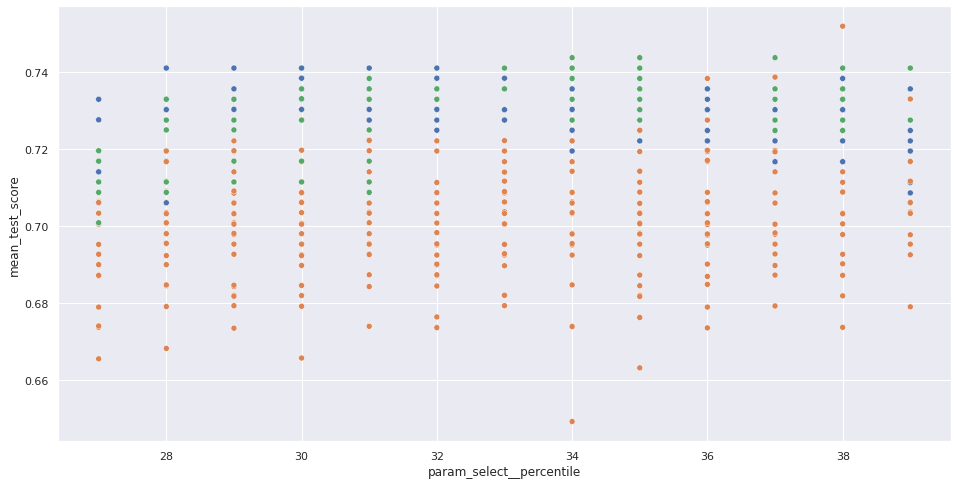

In [939]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
sns.scatterplot(data=lda_cv_params, x="param_select__percentile", y="mean_test_score", hue="param_select__score_func", ax=ax)
ax.legend_.remove()

In [941]:
lda_rscv.score(X, goblin_v_all)

0.7304582210242587

# Pipeline

In [790]:
pipe = Pipeline(steps=[
    ("scale", MaxAbsScaler()),
    ("kbin", ColumnTransformer(transformers=[
        ("kbin", KBinsDiscretizer(encode="ordinal"), [0,1,2,3])
    ], remainder="passthrough")),
    ("var", VarianceThreshold()),
    ("select", SelectPercentile()),
    ("poly", PolynomialFeatures()),
    ("var2", VarianceThreshold()),
    ("select2", SelectPercentile()),
])

param_distributions = {
    "kbin__kbin__n_bins" : stats.randint(4, 20),
    "kbin__kbin__strategy" : ["uniform", "quantile", "kmeans"],
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [mutual_info_classif, f_classif],
    "select__percentile" : stats.randint(70, 80),
    "poly__degree" : stats.randint(1, 3),
    "poly__interaction_only" : [True, False],
    "poly__include_bias" : [True, False],
    "var2__threshold" : stats.uniform(0, 0.01),
    "select2__score_func" : [mutual_info_classif, f_classif],
    "select2__percentile" : stats.randint(20, 30),
}


In [791]:
# X = csr_matrix(X)

# Logistic Regression

In [797]:
lr_pipe = Pipeline(steps=pipe.steps + [
    ("clf", LogisticRegression(
        dual=False,
        class_weight="balanced",
        random_state=0,
        solver="liblinear",
        max_iter=1000,
        multi_class="ovr",
    ))
]) 

lr_param_distributions = {
    **param_distributions,
    "clf__penalty" : ["l1", "l2"],
    "clf__tol" : stats.uniform(0, 1e-2),
    "clf__C" : stats.uniform(0, 5),
    "clf__fit_intercept" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=lr_param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1912 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2638 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3404 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 4364 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 5468 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 6590 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 7752 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 9150 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 30.6min finished


Best RSCV Score: 0.7412280701754386


In [798]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.86      0.95      0.90        57
       Ghoul       0.69      0.84      0.76        63
      Goblin       0.73      0.49      0.59        61

    accuracy                           0.76       181
   macro avg       0.76      0.76      0.75       181
weighted avg       0.76      0.76      0.75       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.77      0.92      0.84        25
       Ghoul       0.74      0.85      0.79        27
      Goblin       0.71      0.46      0.56        26

    accuracy                           0.74        78
   macro avg       0.74      0.74      0.73        78
weighted avg       0.74      0.74      0.73        78



Testing Report
-------------------------------------------

In [799]:
rscv.best_estimator_.fit(X, y)

print(classification_report(y_true=y, y_pred=rscv.best_estimator_.predict(X)))

              precision    recall  f1-score   support

       Ghost       0.80      0.90      0.85       117
       Ghoul       0.72      0.84      0.78       129
      Goblin       0.69      0.49      0.57       125

    accuracy                           0.74       371
   macro avg       0.74      0.74      0.73       371
weighted avg       0.74      0.74      0.73       371



In [506]:
# joblib.dump(rscv.best_estimator_, "logreg.joblib", compress=True)

['logreg.joblib']

# SVM

In [508]:
svm_pipe = Pipeline(steps=pipe.steps + [
    ("clf", SVC(
        probability=True,
        cache_size=200,
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovr",
        random_state=0,
    )),
])

svm_param_distributions = {
    **param_distributions,
    "clf__C" : stats.uniform(0, 5),
    "clf__kernel" : ["linear", "poly", "rbf"],
    "clf__degree" : stats.randint(3, 10),
    "clf__gamma" : ["auto", "scale"],
    "clf__coef0" : stats.uniform(-1, 2),
    "clf__shrinking" : [True, False],
    "clf__tol" : stats.uniform(0, 1e-1),
    "clf__break_ties" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=svm_pipe,
    param_distributions=svm_param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1524 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3452 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4570 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5832 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 7501 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 9400 tasks      | elapsed: 10.2min


Best RSCV Score: 0.7517543859649123


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 10.8min finished


In [509]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.85      0.89      0.87        57
       Ghoul       0.73      0.83      0.78        63
      Goblin       0.72      0.59      0.65        61

    accuracy                           0.77       181
   macro avg       0.77      0.77      0.77       181
weighted avg       0.77      0.77      0.76       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.79      0.92      0.85        25
       Ghoul       0.88      0.85      0.87        27
      Goblin       0.74      0.65      0.69        26

    accuracy                           0.81        78
   macro avg       0.81      0.81      0.80        78
weighted avg       0.81      0.81      0.80        78



Testing Report
-------------------------------------------

Getting coefficients

In [134]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

poly = rscv.best_estimator_.named_steps.poly

var2 = rscv.best_estimator_.named_steps.var2

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

In [135]:
X_ = pd.DataFrame(   
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    poly.transform(X_),
    index=X_.index,
    columns=poly.get_feature_names(X_.columns)
)

X_ = pd.DataFrame(
    var2.transform(X_),
    index=X_.index,
    columns=X_.columns[var2.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

,bone_length,rotting_flesh,hair_length,has_soul,bone_length hair_length,bone_length has_soul,rotting_flesh hair_length,hair_length has_soul
Ghost,-2.022525,3.522754,-3.320910,-3.982051,-1.967386,-2.016802,-0.264424,-3.189473
Ghoul,-2.366212,4.853213,-3.628252,-2.426493,-1.607686,-3.054494,-0.652998,-2.409580
Goblin,1.394166,0.238541,2.573046,2.723686,1.619309,1.838296,2.043326,0.918932


In [510]:
rscv.best_estimator_.fit(X, y)

print(classification_report(y_true=y, y_pred=rscv.best_estimator_.predict(X)))

              precision    recall  f1-score   support

       Ghost       0.85      0.89      0.87       117
       Ghoul       0.78      0.79      0.79       129
      Goblin       0.69      0.66      0.67       125

    accuracy                           0.78       371
   macro avg       0.78      0.78      0.78       371
weighted avg       0.77      0.78      0.77       371



In [511]:
joblib.dump(rscv.best_estimator_, "svm.joblib", compress=True)

['svm.joblib']

# Neural Network

In [521]:
nn_pipe = Pipeline(steps=pipe.steps + [
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100,),
        batch_size="auto",
        max_iter=10000,
        shuffle=True,
        random_state=0,
    )),
])

nn_param_distributions = {
    **param_distributions,
    "clf__activation" : ["identity", "logistic", "tanh", "relu"],
    "clf__solver" : ["lbfgs", "sgd", "adam"],
    "clf__alpha" : stats.uniform(1e-8, 1e-1),
    "clf__learning_rate" : ["constant", "invscaling", "adaptive"],
    "clf__learning_rate_init" : stats.uniform(1e-3, 1e0),
    "clf__power_t" : stats.uniform(0.1, 0.9),
    "clf__tol" : stats.uniform(1e-6, 1e-4),
    "clf__warm_start" : [True, False],
    "clf__momentum" : stats.uniform(0, 1),
    "clf__nesterovs_momentum" : [True, False],
    "clf__validation_fraction" : stats.uniform(0, 0.3),
    "clf__beta_1" : stats.uniform(0, 1),
    "clf__beta_2" : stats.uniform(0, 1),
    "clf__epsilon" : stats.uniform(1e-10, 1e-6),
    "clf__n_iter_no_change" : stats.randint(5, 20),
    "clf__max_fun" : stats.randint(10000, 20000),
}

rscv = RandomizedSearchCV(
    estimator=nn_pipe,
    param_distributions=nn_param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 35.7min


KeyboardInterrupt: 

In [517]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.88      0.93      0.91        57
       Ghoul       0.75      0.81      0.78        63
      Goblin       0.72      0.62      0.67        61

    accuracy                           0.78       181
   macro avg       0.78      0.79      0.78       181
weighted avg       0.78      0.78      0.78       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.77      0.96      0.86        25
       Ghoul       0.79      0.85      0.82        27
      Goblin       0.72      0.50      0.59        26

    accuracy                           0.77        78
   macro avg       0.76      0.77      0.76        78
weighted avg       0.76      0.77      0.76        78



Testing Report
-------------------------------------------

In [518]:
rscv.best_estimator_.fit(X, y)

print(classification_report(y_true=y, y_pred=rscv.best_estimator_.predict(X)))

              precision    recall  f1-score   support

       Ghost       0.84      0.88      0.86       117
       Ghoul       0.77      0.81      0.79       129
      Goblin       0.68      0.62      0.64       125

    accuracy                           0.77       371
   macro avg       0.76      0.77      0.76       371
weighted avg       0.76      0.77      0.76       371



In [519]:
joblib.dump(rscv.best_estimator_, "neuralnet.joblib", compress=True)

['neuralnet.joblib']

# Multinomial Naive Bayes

In [531]:
mnb_pipe = Pipeline(steps=pipe.steps + [
    ("clf", MultinomialNB()),
])

mnb_param_distributions = {
    **param_distributions,
    "clf__alpha" : stats.uniform(0, 1),
    "clf__fit_prior" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=mnb_pipe,
    param_distributions=mnb_param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2634 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3838 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5476 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7158 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 9006 tasks      | elapsed:  8.6min


Best RSCV Score: 0.6190058479532163


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  9.7min finished


In [532]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.78      0.81      0.79        57
       Ghoul       0.48      0.94      0.64        63
      Goblin       0.00      0.00      0.00        61

    accuracy                           0.58       181
   macro avg       0.42      0.58      0.48       181
weighted avg       0.41      0.58      0.47       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.69      0.80      0.74        25
       Ghoul       0.53      0.96      0.68        27
      Goblin       0.00      0.00      0.00        26

    accuracy                           0.59        78
   macro avg       0.41      0.59      0.47        78
weighted avg       0.40      0.59      0.47        78



Testing Report
-------------------------------------------

/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [533]:
rscv.best_estimator_.fit(X, y)

print(classification_report(y_true=y, y_pred=rscv.best_estimator_.predict(X)))

              precision    recall  f1-score   support

       Ghost       0.75      0.78      0.76       117
       Ghoul       0.48      0.94      0.64       129
      Goblin       0.00      0.00      0.00       125

    accuracy                           0.57       371
   macro avg       0.41      0.57      0.47       371
weighted avg       0.41      0.57      0.46       371



/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
joblib.dump(rscv.best_estimator_, "multinomialnb.joblib", compress=True)

['multinomialnb.joblib']

# GaussianNB

In [534]:
gnb_pipe = Pipeline(steps=pipe.steps + [
    ("clf", GaussianNB()),
])

gnb_param_distributions = {
    **param_distributions,
    "clf__var_smoothing" : stats.uniform(1e-11, 1e-6),
}

rscv = RandomizedSearchCV(
    estimator=gnb_pipe,
    param_distributions=gnb_param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3940 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 7601 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 10.1min finished


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [168]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.89      0.84      0.86        57
       Ghoul       0.78      0.71      0.74        63
      Goblin       0.61      0.69      0.65        61

    accuracy                           0.75       181
   macro avg       0.76      0.75      0.75       181
weighted avg       0.76      0.75      0.75       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.73      0.88      0.80        25
       Ghoul       0.77      0.74      0.75        27
      Goblin       0.59      0.50      0.54        26

    accuracy                           0.71        78
   macro avg       0.70      0.71      0.70        78
weighted avg       0.70      0.71      0.70        78



Testing Report
-------------------------------------------

In [169]:
joblib.dump(rscv.best_estimator_, "gaussiannb.joblib", compress=True)

['gaussiannb.joblib']

# Confusion Matrix

## Logistic Regression

In [7]:
logreg = joblib.load("logreg.joblib")

logreg_predict = logreg.predict(X)

logreg_predict = pd.Series(logreg_predict, index=X.index)

logreg_confusion_matrix = pd.DataFrame(
    confusion_matrix(y_true=y, y_pred=logreg_predict),
    index=pd.MultiIndex.from_product([["Actual"], y.sort_values().unique()]),
    columns=pd.MultiIndex.from_product([["Predicted"], y.sort_values().unique()]),
)

logreg_confusion_matrix

Predicted             
                  Ghost Ghoul Goblin
Actual Ghost        109     0      8
       Ghoul          3   109     17
       Goblin        21    39     65

In [15]:
logreg_XyP = pd.concat([X, y, logreg_predict], axis=1)

logreg_XyP.rename(columns={
    0 : "predicted"
}, inplace=True)

<AxesSubplot:xlabel='type', ylabel='hair_length'>

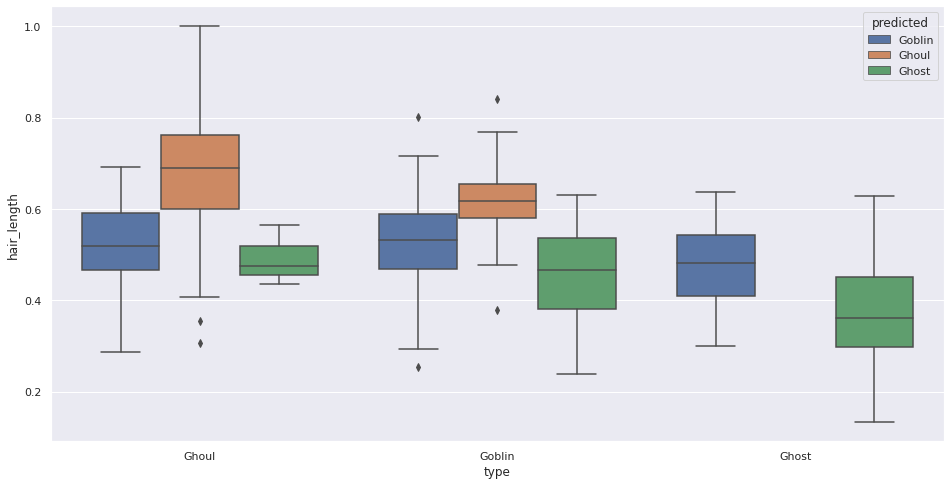

In [17]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="hair_length",
    hue="predicted",
    ax=ax
)

<AxesSubplot:xlabel='type', ylabel='has_soul'>

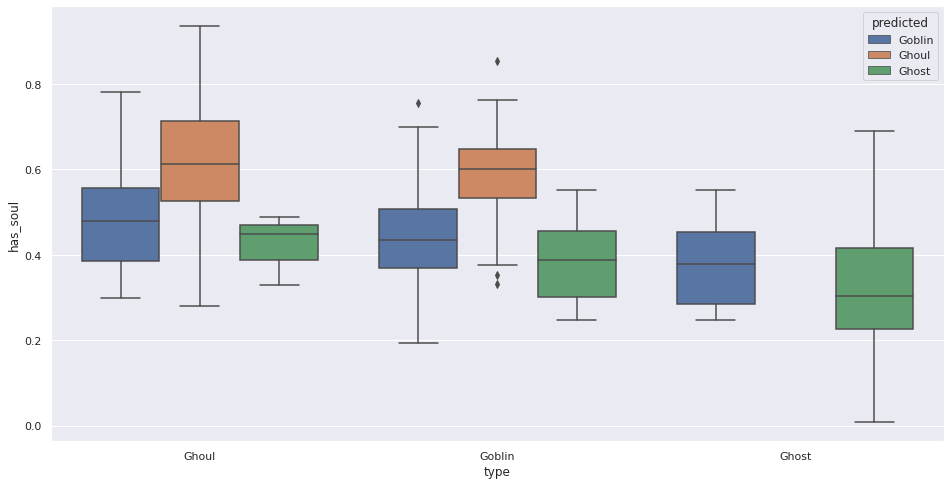

In [18]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="has_soul",
    hue="predicted",
    ax=ax
)

In [90]:
logreg_XyP['averages'] = np.mean([
    logreg_XyP.bone_length,
    logreg_XyP.rotting_flesh,
    logreg_XyP.hair_length,
    logreg_XyP.has_soul,
], axis=0)

logreg_XyP['medians'] = np.median([
    logreg_XyP.bone_length,
    logreg_XyP.rotting_flesh,
    logreg_XyP.hair_length,
    logreg_XyP.has_soul,
], axis=0)

<AxesSubplot:xlabel='type', ylabel='medians'>

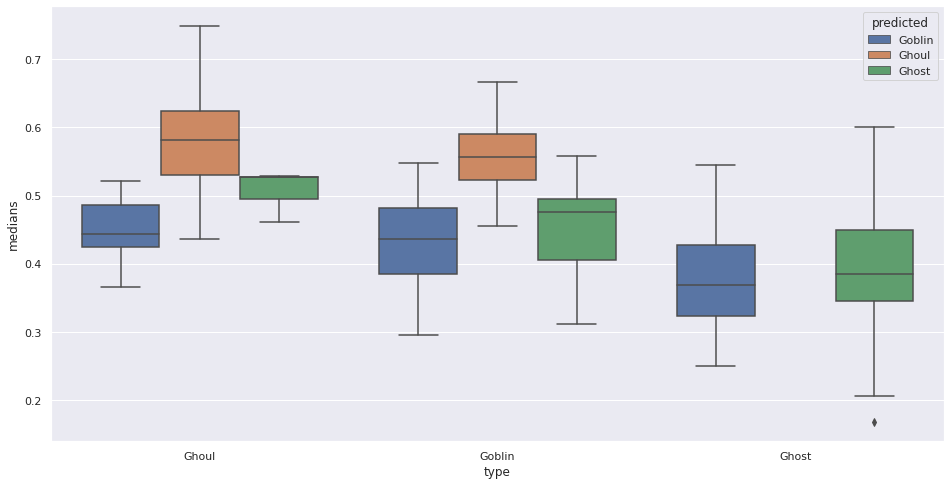

In [94]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="medians",
    hue="predicted",
    ax=ax
)